In [1]:
import sys
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class MyLidcDatatset(Dataset):
    def __init__(self, IMAGES_PATHS, MASK_PATHS, image_size=512):
        """
        IMAGES_PATHS: list of images paths ['./..data_Image/Image/0001_NI000_slice000.png', 
        './..data_Image/Image/0001_NI000_slice001.png']

        MASKS_PATHS: list of masks paths ['./..data_Image/Mask/0001_MA000_slice000.png',
        './..data_Image/Mask/0001_MA000_slice001.png']
        """
        self.image_paths = IMAGES_PATHS
        self.mask_paths = MASK_PATHS
        self.image_size = image_size
        self.transformations = transforms.Compose([transforms.ToTensor()])

    def transform(self, image, mask):
        output_image = Image.new("RGBA", (self.image_size, self.image_size))
        output_image.paste(image, (0, 0))

        mask = mask.convert('L')

        image = self.transformations(output_image)
        mask = self.transformations(mask)

        image, mask = image.type(torch.FloatTensor), mask.type(torch.FloatTensor)

        return image, mask

    def adjust_dimensions(self, image, mask):
        if self.image_size == 512:
            return image, mask
        
        # image resize to the shape
        new_resolution = (self.image_size, self.image_size)
        resized_image = image.resize(new_resolution, Image.Resampling.LANCZOS)
        resized_mask = mask.resize(new_resolution, Image.Resampling.LANCZOS)
        
        return resized_image, resized_mask
        

    def __getitem__(self, index):
        cnt_try = 0
        # loop in case if there are any corrupted files
        while cnt_try < 10 and index < self.__len__():
            try:
                image = Image.open(self.image_paths[index])
                mask = Image.open(self.mask_paths[index])

                image, mask = self.adjust_dimensions(image, mask)

                image, mask = self.transform(image, mask)
                return image, mask, self.image_paths[index]
            
            except Exception as e:
                # if the image is corrupted, load the next image
                print("Corrupted file: ",
                      self.image_paths[index], '  |  ', sys.exc_info()[0])
                print(e)
                index += 1
                cnt_try += 1
        raise ("Could not resolve Corrupted file: ",
               self.image_paths[index], '  |  ', sys.exc_info()[0])

    def __len__(self):
        return len(self.image_paths)

def load_LIDC(image_size=512, combine_train_val=False, mode='Train'):
    # When the mode is Train, it'll load the dataset for training 
    # In case of mode being Test, it'll load the dataset for testing.
    # The combine_train_val indicates if we want to add tran set and validation set.
    # image_size will the resize the according to the python PIL image library.

    # Directory of Image, Mask folder
    IMAGE_DIR = './../data_Image/Image/'
    MASK_DIR = './../data_Image/Mask/'
    meta = pd.read_csv('./../data_Image/meta.csv')

    meta['original_image'] = meta['original_image'].apply(lambda x: (IMAGE_DIR) + x + '.png')
    meta['mask_image'] = meta['mask_image'].apply(lambda x: (MASK_DIR) + x + '.png')

    train_meta = meta[meta['data_split'] == 'Train']
    val_meta = meta[meta['data_split'] == 'Validation']

    if mode == 'Test':
        test_meta = meta[meta['data_split'] == 'Test']
        test_image_paths = list(test_meta['original_image'])
        test_mask_paths = list(test_meta['mask_image'])
        ds = MyLidcDatatset(test_image_paths, test_mask_paths, image_size)
        return ds
    
    # Get all *npy images into list for Train
    train_image_paths = list(train_meta['original_image'])
    train_mask_paths = list(train_meta['mask_image'])

    # Get all *npy images into list for Validation
    val_image_paths = list(val_meta['original_image'])
    val_mask_paths = list(val_meta['mask_image'])

    if combine_train_val:
        train_image_paths.extend(val_image_paths)
        train_mask_paths.extend(val_mask_paths)

        print("*"*50)
        print("The lenght of image: {}, mask folders: {} for train".format(
            len(train_image_paths), len(train_mask_paths)))
        print("*"*50)

        ds = MyLidcDatatset(train_image_paths, train_mask_paths, image_size)
        return ds

    # not combine train and val
    print("*"*50)
    print("The lenght of image: {}, mask folders: {} for train".format(
        len(train_image_paths), len(train_mask_paths)))
    print("The lenght of image: {}, mask folders: {} for validation".format(
        len(val_image_paths), len(val_mask_paths)))
    print("Ratio between Val/ Train is {:2f}".format(
        len(val_image_paths)/len(train_image_paths)))
    print("*"*50)

    # Create Dataset
    train_dataset = MyLidcDatatset(train_image_paths, train_mask_paths, image_size)
    val_dataset = MyLidcDatatset(val_image_paths, val_mask_paths, image_size)
    # test_dataset = MyLidcDataset(test_image_paths, test_mask_paths)

    return train_dataset, val_dataset

In [2]:
ds = load_LIDC(image_size=256, combine_train_val=True, mode='Test')

datal = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        shuffle=True)

data = iter(datal)
image, label, image_path = next(data)

print(image.shape)
print(label.shape)

torch.Size([1, 4, 256, 256])
torch.Size([1, 1, 256, 256])


('./../data_Image/Image/0332_NI000_slice002.png',)


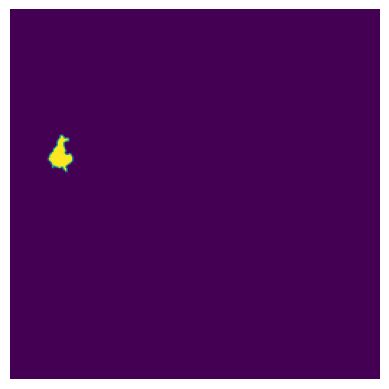

In [3]:
import matplotlib.pyplot as plt

to_pil = transforms.ToPILImage()

# Convert the tensor to a PIL Image
image = to_pil(label[0])
print(image_path)
# print(mask_path[0])
# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()


In [16]:
import os

# path = "./../data_Image/Image/0702_NI004_slice016.png"
filename = os.path.basename(image_path[0]).split(".")[0]

print(filename)

0624_NI003_slice019
